In [2]:
import os
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image

from pycocotools.coco import COCO

In [3]:
train_json  = './data/labels/train.json'
submit_json = './data/labels/answer_sample.json'

coco        = COCO(train_json)
coco_submit = COCO(submit_json)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [4]:
print(coco.getCatIds())

[coco.loadCats(i)[0]['name'] for i in range(8)]

[0, 1, 2, 3, 4, 5, 6, 7]


['농어', '베스', '숭어', '강준치', '블루길', '잉어', '붕어', '누치']

In [5]:
# Create train_data_info in dictionary

from collections import defaultdict

train_dict = defaultdict(list)

for i in range(149821):
    try:
        # annotation_id를 기반으로 annotation dict의 전체 정보를 return
        ann_info = coco.loadAnns(i)[0]

        image_id = ann_info['image_id']
        category = ann_info['category_id']
        bbox     = ann_info['bbox']

        file_name = coco.loadImgs(image_id)[0]['file_name']

        train_dict[file_name].append((image_id, category, bbox))
    except:
        pass

In [6]:
len(train_dict)

5561

In [7]:
# 한 이미지에 최대 8개의 물고기(라벨)가 존재.

cnt = 0

len_list = set()

for i in train_dict.items():
    len_list.add(len(i[1]))
    
print(len_list)

{1, 2, 3, 4, 5, 6, 7, 8}


In [8]:
categories_info = {f"{coco.loadCats(i)[0]['name']}/{idx}": len(coco.getAnnIds(catIds=i)) for idx, i in enumerate(coco.getCatIds())}

print(f"{categories_info}\ntotal : {sum(categories_info.values())}")

{'농어/0': 180, '베스/1': 2344, '숭어/2': 651, '강준치/3': 2132, '블루길/4': 101, '잉어/5': 159, '붕어/6': 148, '누치/7': 586}
total : 6301


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
/home/yebu/anaconda3/envs/med_com/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yebu/anaconda3/envs/med_com/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'NanumGothicCoding'

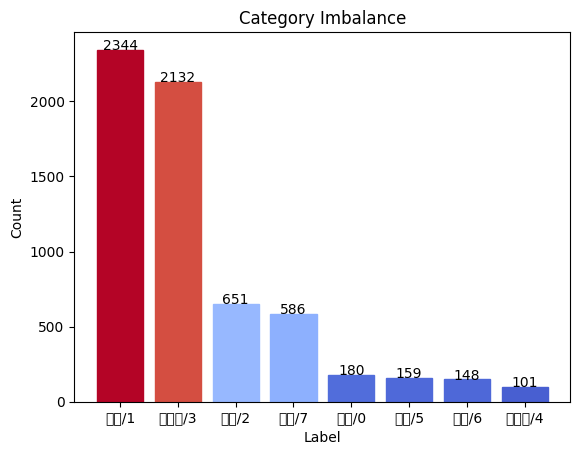

In [9]:
from collections import OrderedDict
import matplotlib.pyplot as plt

# 딕셔너리 데이터 정렬
visualize_dict = OrderedDict(sorted(categories_info.items(), key=lambda x: x[1], reverse=True))

# 딕셔너리의 키와 값을 추출
keys = list(visualize_dict.keys())
values = list(visualize_dict.values())

# 컬러맵 선택
cmap = plt.get_cmap('coolwarm')

# 바 그래프 생성
bars = plt.bar(keys, values)

# 컬러맵을 사용하여 바 그래프의 색상 설정
for bar, value in zip(bars, values):
    bar.set_color(cmap(value / max(values)) )

# 그래프에 레이블 추가
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.1, str(value), ha='center')

# 그래프 제목 및 레이블 설정
plt.title('Category Imbalance')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()

## 블루길, 붕어, 잉어, 농어, 누치, 숭어 순으로 부족함.

- 이미지에 위 해당하는 물기가 단일로 찍혀있는 이미지가 있는지 확인.

- 숭어 / 누치 (2, 7)
    - approximately X 3



- 블루길 붕어 잉어 농어 (0, 4, 5, 6)
    - approximately X 20

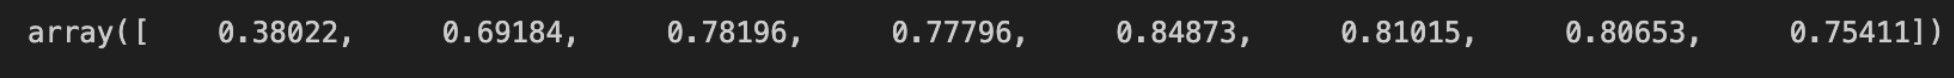

- 농어가 가장 부정확함.
- 그 다음이 베스인데, label 수는 가장 많은데 두 번쨰로 부정확함.
- 다음으로 누치, 강준치, 숭어, 붕어, 잉어, 블루길

# 이미지 내에서 물고기들을 크롭해서 따로 저장

In [10]:
# 해당 카테고리에 해당하는 image_id
fish_cat = {
    '농어' : 0, 
    '베스' : 1, 
    '숭어': 2, 
    '강준치': 3, 
    '블루길': 4,
    '잉어': 5, 
    '붕어': 6, 
    '누치': 7, 
}

normal_cat = [fish_cat['베스'], fish_cat['강준치']]
low_cat    = [fish_cat['숭어'], fish_cat['누치']]
exlow_cat  = [fish_cat['블루길'], fish_cat['붕어'], fish_cat['잉어'], fish_cat['농어']]

In [11]:
normal_cat_bass = coco.getImgIds(catIds=fish_cat['베스'])
normal_cat_gang = coco.getImgIds(catIds=fish_cat['강준치'])

low_cat_soong   = coco.getImgIds(catIds=fish_cat['숭어'])
low_cat_nu      = coco.getImgIds(catIds=fish_cat['누치'])

exlow_cat_blue  = coco.getImgIds(catIds=fish_cat['블루길'])
exlow_cat_bung  = coco.getImgIds(catIds=fish_cat['붕어'])
exlow_cat_ing   = coco.getImgIds(catIds=fish_cat['잉어'])
exlow_cat_nong  = coco.getImgIds(catIds=fish_cat['농어'])

img_id_list = [normal_cat_bass, normal_cat_gang, low_cat_soong, low_cat_nu, exlow_cat_blue, exlow_cat_bung, exlow_cat_ing, exlow_cat_nong]

In [12]:
print(coco.getImgIds(catIds=1))

print(coco.loadImgs(90117))

[90117, 106502, 24585, 24586, 24587, 139274, 24589, 24590, 139275, 24592, 24597, 90133, 16408, 16409, 16410, 98332, 98333, 98334, 106525, 65572, 131109, 65576, 24619, 131117, 98355, 98356, 90180, 90181, 90182, 90184, 90185, 24651, 106576, 106577, 98400, 98401, 98403, 90225, 106619, 49324, 139440, 139442, 139455, 139457, 98503, 98504, 82126, 82127, 82130, 82137, 90336, 65761, 90338, 106725, 82150, 82151, 98534, 82153, 82154, 98535, 98536, 98537, 98541, 98542, 98543, 98544, 98545, 98546, 98548, 98549, 98550, 98554, 98555, 98556, 98559, 98560, 98567, 98568, 90378, 106762, 106763, 98582, 106778, 90417, 90418, 98612, 139574, 98616, 98617, 98618, 98619, 98620, 106808, 98622, 98623, 98625, 49474, 49475, 90435, 98626, 98627, 98628, 98629, 98630, 98638, 98639, 98640, 106832, 90460, 106848, 106851, 49509, 49510, 49511, 106870, 90488, 90489, 106875, 106878, 139646, 139648, 98711, 98712, 98713, 65948, 90531, 106919, 106922, 106923, 106924, 106928, 106929, 106931, 98749, 98750, 98751, 98752, 98753,

# Crop fish bbox

In [13]:
all_img_id = coco.getImgIds()

coco.loadImgs(1)[0]

all_img_name = [coco.loadImgs(i)[0]['file_name'] for i in all_img_id]

In [14]:
print(all_img_id[:5], all_img_name[:5])

[1, 3, 4, 5, 6] ['train_0.png', 'train_1.png', 'train_2.png', 'train_3.png', 'train_4.png']


In [15]:
img_name_dict = {id: name for id, name in zip(all_img_id, all_img_name)}

In [16]:
all_label_info = []

for i in range(149821):
    try:
        all_info = coco.loadAnns(i)[0]
        img_id, bbox, cat = img_name_dict[all_info['image_id']], all_info['bbox'], all_info['category_id']
        all_label_info.append([img_id, cat, bbox])
    except:
        pass

In [17]:
all_label_info[:5]

[['train_0.png', 3, [37.98, 209.94, 369.19, 110.89]],
 ['train_185.png', 5, [57.07, 247.17, 384.16, 130.69]],
 ['train_186.png', 5, [96.59, 236.87, 427.01, 137.82]],
 ['train_192.png', 5, [154.41, 254.3, 467.41, 134.65]],
 ['train_194.png', 5, [26.18, 222.61, 409.5, 171.09]]]

In [18]:
fish_cat_folder = {
    0: 'exlow_nong', 
    1: 'normal_bass', 
    2: 'low_sung', 
    3: 'normal_gang', 
    4: 'exlow_blue', 
    5: 'exlow_ing', 
    6: 'exlow_bung', 
    7: 'low_nu', 
}

In [35]:
os.makedirs('./data/crop/crop_fish', exist_ok=True)

for folder_name in fish_cat_folder.values():
    os.makedirs(f'./data/crop/crop_fish/{folder_name}', exist_ok=True)
    os.makedirs(f'./data/crop/output/{folder_name}', exist_ok=True)
    os.makedirs(f'./data/mixup/{folder_name}', exist_ok=True)

In [24]:
from PIL import Image
from tqdm import tqdm
"""
norm  [normal_bass, normal_gang]
low   [low_sung, low_nu]
exlow [exlow_blue, exlow_bung, exlow_ing, exlow_nong]
"""
train_img_dir = './data/train/'
crop_img_dir  = './data/crop/crop_fish/'

def crop_and_save_images(img_folder):

    for image_info in tqdm(img_folder):
        image_name = image_info[0]
        category   = image_info[1]
        bbox       = image_info[2]

        # 이미지 파일 로드
        image = Image.open(train_img_dir + image_name)
        
        # bbox 좌표 추출
        x, y, w, h = bbox
        x_min = x
        y_min = y
        x_max = x + w
        y_max = y + h
        
        # bbox 영역 crop
        cropped_image = image.crop((int(x_min), int(y_min), int(x_max), int(y_max)))

        try:
            full_crop_img_dir = crop_img_dir + fish_cat_folder[category]

            save_name = f"{full_crop_img_dir}/{image_name.split('.')[0]}.png"
            cropped_image.save(save_name)

        except:
            pass

# 함수 호출
crop_and_save_images(all_label_info)

100%|██████████| 6301/6301 [00:37<00:00, 166.53it/s]


In [25]:
# ms-coco의 bbox annotation은 yolo format으로 변환. 좌상단 x, y좌표, width, height 기반을 정규화된 center x,y 와 width, height로 변환. 
def bbox_2_yolo(bbox, img_w, img_h):
    # ms-coco는 좌상단 x, y좌표, width, height
    x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]

    # center x좌표는 좌상단 x좌표에서 width의 절반을 더함. center y좌표는 좌상단 y좌표에서 height의 절반을 더함. 
    centerx = bbox[0] + w / 2
    centery = bbox[1] + h / 2

    # centerx, centery, width, height를 이미지의 width/height로 정규화. 
    dw = 1 / img_w
    dh = 1 / img_h
    centerx *= dw
    w *= dw
    centery *= dh
    h *= dh

    return centerx, centery, w, h


bbox_2_yolo(bbox=[434, 111, 185, 78], img_w=640, img_h=480)

(0.8226562500000001, 0.3125, 0.2890625, 0.1625)

In [31]:
import random
from PIL import Image
import os

fish_cat = {
    'exlow_nong'  : 0, 
    'normal_bass' : 1, 
    'low_sung'    : 2, 
    'normal_gang' : 3, 
    'exlow_blue'  : 4,
    'exlow_ing'   : 5, 
    'exlow_bung'  : 6,
    'low_nu'      : 7
}

def composite_images(bg_dir, fish_label, create_cnt):

    crop_dir = './data/crop/crop_fish/'
    output_dir = './data/crop/output/'

    # background 폴더의 이미지 파일 목록 가져오기 (배경이미지들)
    bg_images = os.listdir(bg_dir)
    
    # 크롭된 물고기 이미지들
    fish_images = os.listdir(crop_dir + fish_label)


    cnt = 0
    while create_cnt:

        # 배경과 크롭 이미지 무작위 선택
        bg = random.choice(bg_images)
        crop_image_name = random.choice(fish_images)  # B 폴더의 crop된 이미지 파일 이름은 A 폴더의 이미지 파일 이름과 동일한 것으로 가정

        # bg 이미지 파일 경로 (배경이미지)
        bg_image_path = os.path.join(bg_dir, bg)

        # crop된 이미지 파일 경로 (물고기 크롭)
        crop_image_path = os.path.join(crop_dir, fish_label, crop_image_name)
        
        # bg 이미지 열기
        bg_image = Image.open(bg_image_path)
        bg_width, bg_height = bg_image.size
        
        # crop 이미지 열기
        crop_image = Image.open(crop_image_path)
        crop_width, crop_height = crop_image.size
        
        # bg 이미지 내에서 랜덤한 위치 계산
        max_x = bg_width - crop_width
        max_y = bg_height - crop_height
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        # xywh-format to YOLO-format(centerx, centery, w, h)
        xywh_bbox = [x, y, crop_width, crop_height]
        yolo_bbox = bbox_2_yolo(xywh_bbox, 640, 480)

        yolo_final = [fish_cat[fish_label], yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]]

        # B 이미지를 A 이미지 위에 합성
        composite_image = Image.new('RGB', (640, 480), (250, 250, 250))
        composite_image.paste(bg_image, (0, 0))
        composite_image.paste(crop_image, (x, y))
        
        # 저장할 이미지 파일 경로
        output_image_path = os.path.join(output_dir, fish_label)
        
        # 합성된 이미지 저장
        composite_image.save(output_image_path + f'/{fish_label}_{cnt}.jpg')

        # save YOLO-format label.text
        with open(f'{output_image_path}/{fish_label}_{cnt}.txt', 'w+') as f:
            for i in yolo_final:
                f.write(f'{i} ')
       
        cnt += 1
        create_cnt -= 1
    
    
# 함수 호출
bg_dir = './data/crop/crop_background/'

crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong']

for i in tqdm(crop_folder_list):
    composite_images(bg_dir=bg_dir, fish_label=i, create_cnt=2500)

100%|██████████| 8/8 [02:33<00:00, 19.16s/it]


In [ ]:
### ------------------------------------------------- ###
### ----------- 해당 폴더 내 모든 파일 삭제 ----------- ###
### ------------------------------------------------- ###

# remove_dir = './data/crop/crop_fish/'
# remove_dir = './data/crop/output/'
remove_dir = './data/mixup/'

crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong']

def DeleteAllFiles(filePath):
    if os.path.exists(filePath):
        for file in os.scandir(filePath):
            os.remove(file.path)
        return 'Remove All File'
    else:
        return 'Directory Not Found'

for i in crop_folder_list:
    DeleteAllFiles(remove_dir + i)

### ------------------------------------------------- ###
### ------------------------------------------------- ###
### ------------------------------------------------- ###

# Mix-up

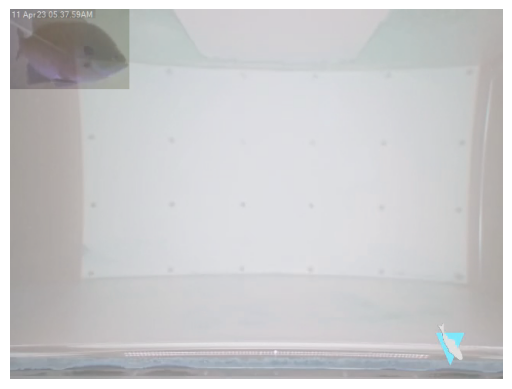

In [33]:
import torchvision
import requests
from PIL import Image
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt

bg_img   = cv2.imread("./data/crop/crop_background/train_15.png")
fish_img = Image.open("./data/crop/crop_fish/exlow_blue/train_13319.png")


# Create fish image with 640x480
composite_img = Image.new('RGB', (640, 480), (250, 250, 250))
composite_img.paste(fish_img, (0, 0))
composite_img = np.array(composite_img)

def mixup(x1, x2, y1, y2, lambda_=0.5):
    # 믹스업 할 때 공식, 논문에 그대로 나온다.
    x = lambda_ * x1 + (1-lambda_) * x2 
    y = lambda_ * y1 + (1-lambda_) * y2
    return x, y

x, y = mixup(bg_img, composite_img, np.array([1,0]), np.array([0,1]), lambda_=0.5)

plt.axis('off')
plt.imshow(x.astype(int)), y
plt.show()
# np.array에서 첫번째 = cat label, 두번째(0) = dog label

# cv2.COLOR_BGR2RGB를 하지 않으면 색상이 이상하게 나온다.
# cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
# cv2.imshow("Test", cat_img)
# cv2.waitKey(0)

In [36]:
import random
from PIL import Image
import os
from tqdm import tqdm

fish_cat = {
    'exlow_nong'  : 0, 
    'normal_bass' : 1, 
    'low_sung'    : 2, 
    'normal_gang' : 3, 
    'exlow_blue'  : 4,
    'exlow_ing'   : 5, 
    'exlow_bung'  : 6,
    'low_nu'      : 7
}

def mixup(x1, x2, y1, y2, lambda_=0.5):
    # 믹스업 할 때 공식, 논문에 그대로 나온다.
    x = lambda_ * x1 + (1-lambda_) * x2 
    y = lambda_ * y1 + (1-lambda_) * y2
    return x, y

def composite_images(
                     fish_label, create_cnt, 
                     bg_dir           = './data/crop/crop_background/', 
                     crop_dir         = './data/crop/crop_fish/', 
                     crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong'], 
                     output_dir       = './data/crop/output/', 
                    ):
    
    # background 폴더의 이미지 파일 목록 가져오기 (배경이미지들)
    bg_images = os.listdir(bg_dir)
    
    # 크롭된 물고기 이미지들
    fish_images = os.listdir(crop_dir + fish_label)


    cnt = 0
    while create_cnt:

        # 배경과 크롭 이미지 무작위 선택
        bg = random.choice(bg_images)
        crop_image_name = random.choice(fish_images)  # B 폴더의 crop된 이미지 파일 이름은 A 폴더의 이미지 파일 이름과 동일한 것으로 가정

        # bg 이미지 파일 경로 (배경이미지)
        bg_image_path = os.path.join(bg_dir, bg)

        # crop된 이미지 파일 경로 (물고기 크롭)
        crop_image_path = os.path.join(crop_dir, fish_label, crop_image_name)
        
        # bg 이미지 열기
        bg_image = Image.open(bg_image_path)
        bg_width, bg_height = bg_image.size
        
        # crop 이미지 열기
        crop_image = Image.open(crop_image_path)
        crop_width, crop_height = crop_image.size
        
        # bg 이미지 내에서 랜덤한 위치 계산
        max_x = bg_width - crop_width
        max_y = bg_height - crop_height
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        # xywh-format to YOLO-format(centerx, centery, w, h)
        xywh_bbox = [x, y, crop_width, crop_height]
        yolo_bbox = bbox_2_yolo(xywh_bbox, 640, 480)

        yolo_final = [fish_cat[fish_label], yolo_bbox[0], yolo_bbox[1], yolo_bbox[2], yolo_bbox[3]]

        # B 이미지를 A 이미지 위에 합성
        composite_image = Image.new('RGB', (640, 480), (250, 250, 250))
        # composite_image.paste(bg_image, (0, 0))
        composite_image.paste(crop_image, (x, y))
        
        # mixup을 위해 PIL로 읽어온 이미지를 array형태로 변환
        bg_image        = np.array(bg_image)
        composite_image = np.array(composite_image)
        
        # 배경과 crop된 물고기 이미지를 mixup
        x, y = mixup(bg_image, composite_image, np.array([1,0]), np.array([0,1]), lambda_=0.5)
        
        # array형태로 바뀌어 있는 이미지를 다시 PIL 이미지로
        x = Image.fromarray(x.astype(np.uint8))
        
        
        # 저장할 이미지 파일 경로
        output_image_path = os.path.join(output_dir, fish_label)
        
        # 합성된 이미지 저장
        # composite_image.save(output_image_path + f'/{fish_label}_{cnt}.jpg')
        x.save(output_image_path + f'/{fish_label}_{cnt}.jpg')

        # save YOLO-format label.text
        with open(f'{output_image_path}/{fish_label}_{cnt}.txt', 'w+') as f:
            for i in yolo_final:
                f.write(f'{i} ')
       
        cnt += 1
        create_cnt -= 1
    

# 함수 호출
# crop_folder_list = ['normal_bass', 'normal_gang', 'low_sung', 'low_nu', 'exlow_blue', 'exlow_bung', 'exlow_ing', 'exlow_nong']
crop_folder_list = ['normal_bass', 'exlow_nong']

for i in tqdm(crop_folder_list):
    if i == 'exlow_nong':
        image_num = 2000
    else:
        image_num = 500
    composite_images(fish_label=i, create_cnt=image_num, output_dir='./data/mixup/')

100%|██████████| 2/2 [00:28<00:00, 14.09s/it]


In [37]:
from glob import glob

# 전체 train data의 경로를 가지고있는 txt파일 + 위에서 추가로 생성한 이미지들의 경로를 가진 txt파일을 합쳐야함.
crop_train = './data/YOLO/crop_stratified/train.txt'

add_image_list = []
crop_folder_list = ['normal_bass', 'exlow_nong']
for i in crop_folder_list:
    add_image_list.append(glob(f'./data/mixup/{i}/*.jpg'))
    
add_image_list = sum(add_image_list, [])
len(add_image_list)

2500

In [38]:
with open('./data/mixup/train.txt', 'a') as f:
    for i in add_image_list:
        f.write(f'{i}\n')

# YOLO train/test 합치기

In [39]:
from glob import glob
import os
import shutil

with open('./data/mixup/train.txt', 'w+') as f:
    for i in add_image_list:
        f.write(f'{i}\n')
        
with open('./data/mixup/train.txt', 'a') as f:
    for i in glob(f'./data/yolo_train_test_stratified/train/*.png'):
        f.write(f'{i}\n')

# Train-Test-Split (Stratified)

In [40]:
# 크롭된 모든 이미지들의 경로정보를 가진 .txt파일 만들기

crop_dir         = './data/crop/output/'
crop_folder_list = ['exlow_nong', 'normal_bass', 'low_sung', 'normal_gang', 'exlow_blue', 'exlow_ing', 'exlow_bung', 'low_nu']

with open(f'{crop_dir}all_data.txt', 'w+') as f:
    for folder in tqdm(crop_folder_list):
        img_list = os.listdir(crop_dir + folder)
        for img in img_list:
            if img[-3:] == 'txt':
                continue
            f.write(f'{crop_dir}{folder}/{img}\n')

fish_cat = {
    'exlow_nong'  : 0, 
    'normal_bass' : 1, 
    'low_sung'    : 2, 
    'normal_gang' : 3, 
    'exlow_blue'  : 4,
    'exlow_ing'   : 5, 
    'exlow_bung'  : 6,
    'low_nu'      : 7
}
labels = []

for i in crop_folder_list:
    for _ in range(2500):
        labels.append(fish_cat[i])

100%|██████████| 8/8 [00:00<00:00, 423.60it/s]


In [41]:
data_list = []

with open('./data/crop/output/all_data.txt', 'r') as f:
    while True:
        line = f.readline()
        if not line:
            break
        data_list.append(line.strip())

In [43]:
from sklearn.model_selection import train_test_split

data  = data_list
label = labels

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=2023)

In [44]:
with open('./data/YOLO/crop_stratified/train.txt', 'w+') as f:
    for line in X_train:
        f.write(f'{line}\n')
    
with open('./data/YOLO/crop_stratified/test.txt', 'w+') as f:
    for line in X_test:
        f.write(f'{line}\n')

# Create YOLO-format label.txt from train_data

In [45]:
from glob import glob

'./data/yolo_train_test_stratified/test'
'./data/yolo_train_test_stratified/train'


len(glob('./data/yolo_train_test_stratified/train/*.png')), len(glob('./data/yolo_train_test_stratified/test/*.png'))

(0, 0)

# train-test split

In [ ]:
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

X, y = make_multilabel_classification(n_samples=1000, n_features=10, n_classes=8, n_labels=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42, shuffle=True, stratify=y)

In [ ]:
# 원본 json파일에서 annotation이 존재하는 이미지만 추출
# 그 후 stratified train/test 분할

# 